### import libraries

In [1]:
import string
import math
import random
import sys
import os
import re
import collections
from math import sqrt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
import xgboost
from sklearn.neural_network import MLPClassifier
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.layers.embeddings import Embedding
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
lmtzr = WordNetLemmatizer()

/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### prequirements 

In [2]:
removephrases = [
    'media playback is unsupported on your device',
    'image copyright',
    'getty images',
    'media caption',
    'image caption',
    '(reuters)',
    '(upi)',
    'getty',
    '(cnn)',
    'advertisement',
]

### category class

In [3]:
class ArticleCrawled():
    def __init__(self, heading, text, link, signature, shingles):
        self.heading = heading
        self.text = text
        self.link = link
        self.signature = signature
        self.shingles = shingles

class Category():
    def __init__(self, name, links, token_list, articles, test, test_articles, test_categories, train):
        self.name = name
        self.links = links
        self.token_list = token_list #a token is a sentence
        self.test = test
        self.test_articles = test_articles
        self.test_categories = test_categories
        self.train = train
        self.articles = articles

### read data

In [4]:
def ReadDataSet():
    print("Reading in data from files")
    total_sentences = 0
    data_dir = os.getcwd() + '/data'
    for dirname in os.listdir(data_dir):
        for filename in os.listdir(data_dir + "/" + dirname):
            if 'articles' in filename:
                #create new category if needed
                category_exists = False
                for category in categories:
                    if category.name == filename.split('.')[0]:
                        category_exists = True
                if not category_exists:
                    new_category = Category(name = filename.split('.')[0], links = [], 
                                            token_list = [], articles = [], train = [], 
                                            test = [], test_articles = [], test_categories = [])
                    categories.append(new_category)

    #read articles into category articles
    total_articles = 0
    category_count = []
    seen = set()
    for category in categories:
        for dirname in os.listdir(data_dir):
            try:
                filename = data_dir + "/" + dirname + "/" + category.name + ".txt"
                file = open((filename),"r") 
                for line in file: 
                    #must contain letters and be longer than 5 characters long
                    if any(c.isalpha()for c in line) and len(line) > 5:
                        article = line.split(":::::")
                        heading = article[0]
                        text = article[1]

                        if line not in seen:
                            seen.add(line)

                            minArticleLength = 100
                            if len(line.split()) > minArticleLength:
                                total_articles += 1
                                newArticle = ArticleCrawled(heading = heading, 
                                                            text = heading + ' ' + text, 
                                                            link = None, signature = [], 
                                                            shingles = [])
                                category.articles.append(newArticle)
                                category_count.append(category.name)
                file.close()
            except Exception as e:
                print(e)
    print ("Total Articles read: " + str(total_articles))
    return category_count

### explore data

Reading in data from files
Total Articles read: 2336
(set(['sports_articles', 'business_articles', 'tech_articles', 'science and health_articles', 'entertainment and arts_articles', 'Politics_articles']), [502, 281, 435, 430, 276, 412])


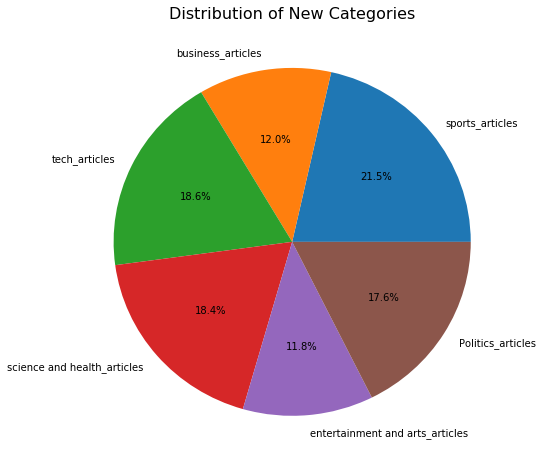

In [6]:
categories = []
train_articles, test_articles = [],[]
train_categories, test_categories = [],[]
category_count = ReadDataSet()

if not os.path.exists("figure"):
    os.makedirs("figure")

labels = set(category_count)
counts = [category_count.count(label) for label in labels]
print(labels, counts)
plt.figure(figsize=(8,8))
plt.pie(counts, labels=labels, autopct='%1.1f%%')
plt.title("Distribution of New Categories", fontsize = 16)
plt.savefig("figure/Distribution of New Categories.png")
plt.show()

### clean data

In [7]:
#trim out dataset
def CleanData():
    print("Cleaning data")
    cachedStopWords = stopwords.words("english")
    for category in categories:
        newList = []
        i = 0
        while i < len(category.articles):
            # lower the letters
            category.articles[i].text = category.articles[i].text.lower()

            #remove header divider
            category.articles[i].text = re.sub(":::::", ' ', category.articles[i].text)   

            #remove bad phrases
            for phrase in removephrases:
                category.articles[i].text = re.sub(phrase, '', category.articles[i].text)   

            #remove easy punctation
            category.articles[i].text = re.sub(r"[,.;@#?!&$-]+\ *", " ", category.articles[i].text)   

            #remove punctuation
            category.articles[i].text = "".join(l for l in category.articles[i].text if l not in string.punctuation)   

            #remove stop words
            category.articles[i].text = ' '.join([word for word in category.articles[i].text.split() if word not in cachedStopWords])

            #finally condense whitespace
            category.articles[i].text = re.sub('\s+',' ',category.articles[i].text)

            i += 1
    print("Finished cleaning data")

### visualize data

In [8]:
CleanData()

Cleaning data


/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:26: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


Finished cleaning data


science and health_articles


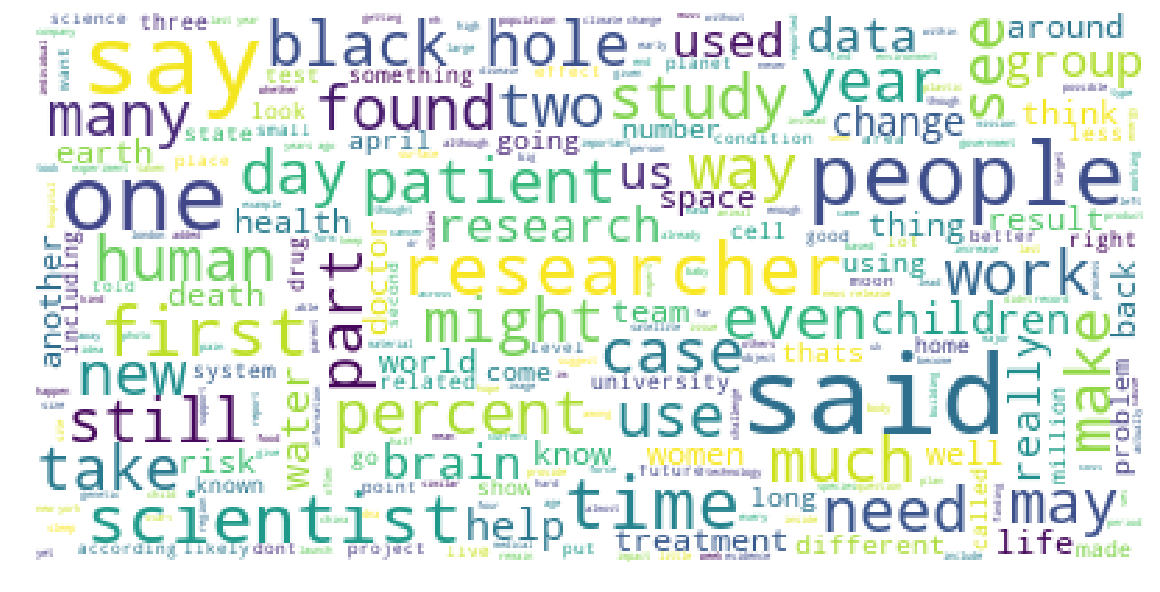

Politics_articles


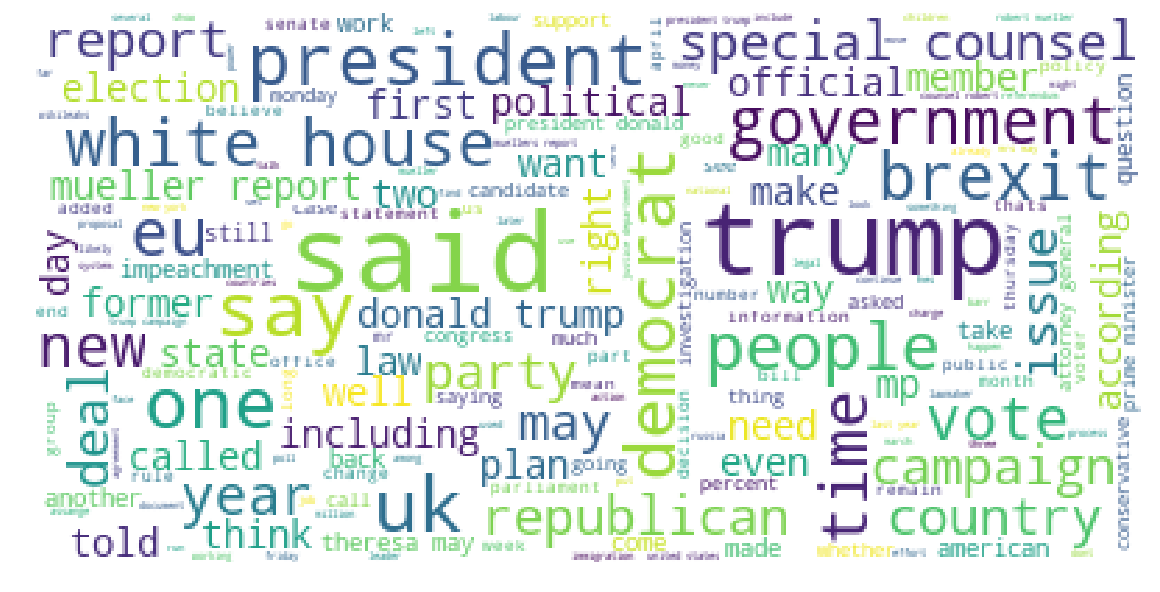

entertainment and arts_articles


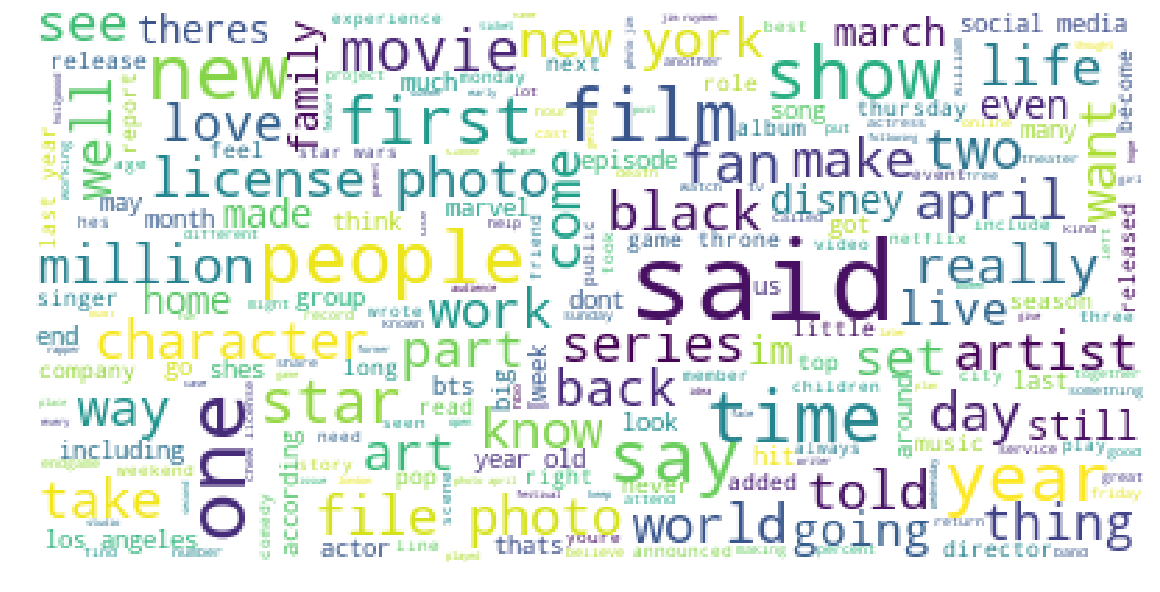

sports_articles


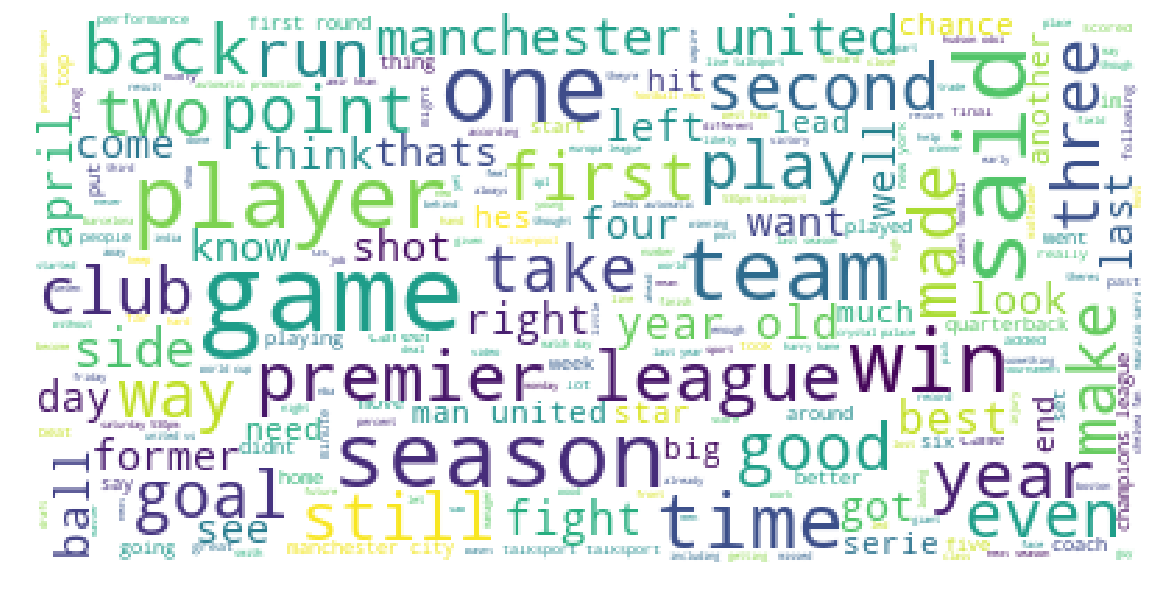

tech_articles


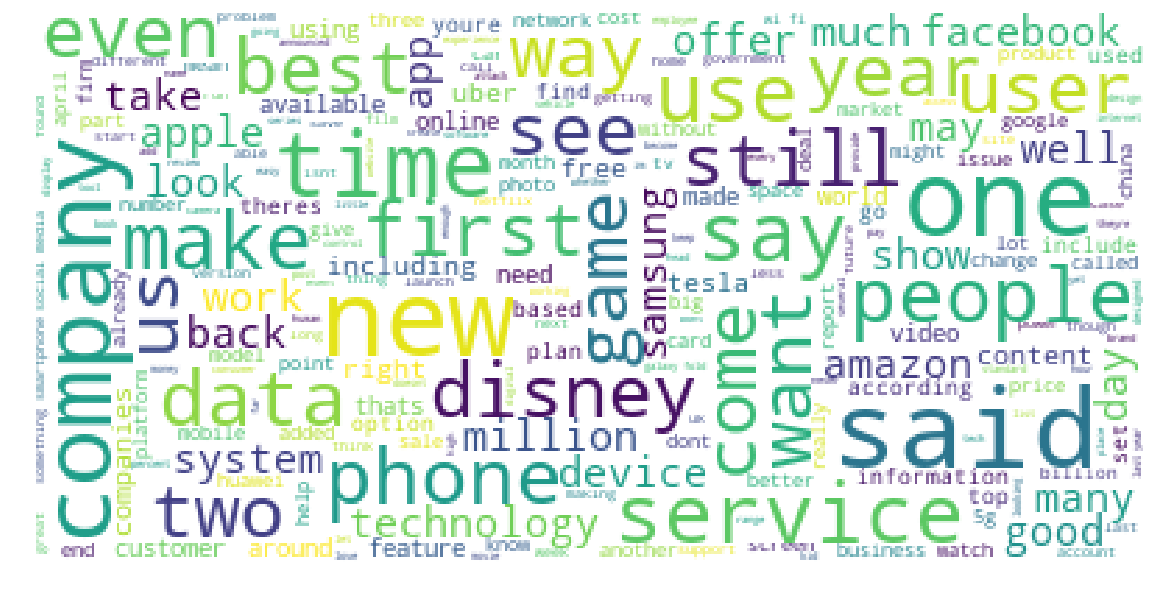

business_articles


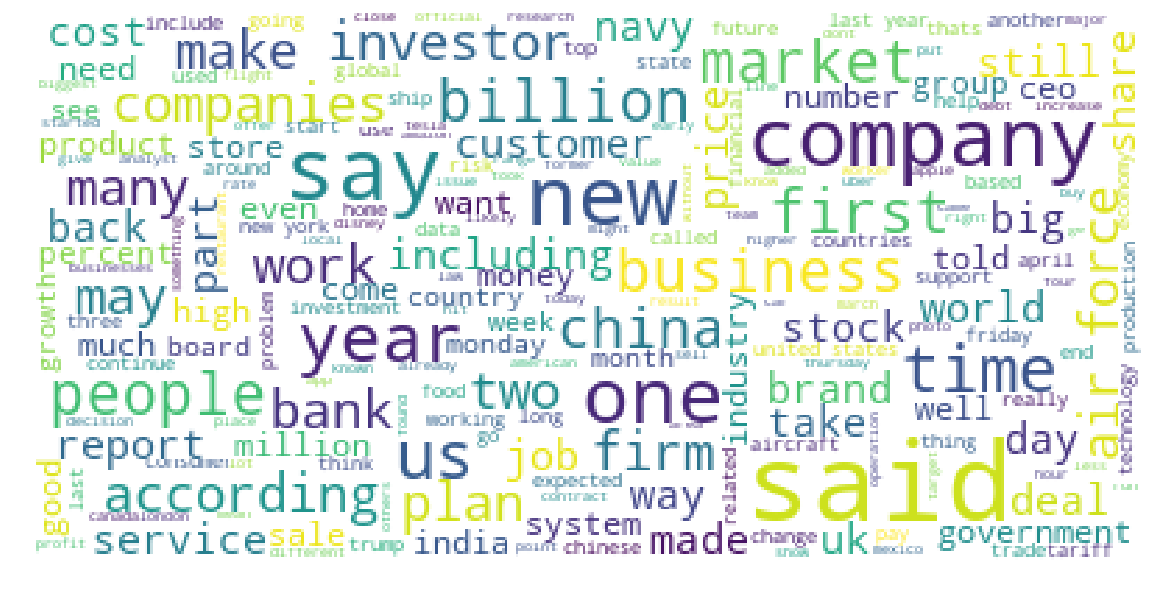

In [9]:
from wordcloud import WordCloud
for category in categories:
    article_list = []
    print(category.name)
    for article in category.articles:
        article_list.append(article.text)
        text = " ".join(article_list)
       
    wordcloud = WordCloud().generate(text)
    plt.figure()
    plt.subplots(figsize=(20,12))
    wordcloud = WordCloud(
        background_color="white",
        max_words=len(text),
        max_font_size=40,
        relative_scaling=.5).generate(text)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.savefig("figure/"+category.name+".png")
    plt.show()

### split data

In [10]:
def SplitTrainTest():
    #shuffle arrays
    for category in categories:
        random.shuffle(category.articles)

    #find train and test sets for each category
    for category in categories:
        c_length = len(category.articles)
        category.train = category.articles[: int(.8 *c_length)]
        category.test = category.articles[int(.8 *c_length):c_length]
        for article in category.test:
            category.test_articles.append(article.text)
            category.test_categories.append([category.name])
            test_articles.append(article.text)
            test_categories.append([category.name])

    #extract train articles into array
    for category in categories:
        for article in category.train:
            train_articles.append(article.text)
            train_categories.append([category.name])

In [11]:
SplitTrainTest()

### Word Level TF-IDF Vectors as features

In [22]:
x_train = np.array(train_articles)
x_test = np.array(test_articles)
count_vect = CountVectorizer()
# choose the first 10,000 most frequent words
count_vect.set_params(max_features=10000)

tfidf_transformer = TfidfTransformer()
x_train_counts = count_vect.fit_transform(x_train)
x_train_tfidf = tfidf_transformer.fit_transform(x_train_counts)

x_test_counts = count_vect.transform(x_test)
x_test_tfidf = tfidf_transformer.transform(x_test_counts)

label_list = ["science and health_articles", "Politics_articles", 
                   "entertainment and arts_articles", "sports_articles",
                   "tech_articles", "business_articles"]
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(label_list)
 #one-hot encode target column
y_train = np.array(label_encoder.transform(train_categories))
y_train_one = to_categorical(y_train)
y_test = np.array(label_encoder.transform(test_categories))
y_test_one = to_categorical(y_test)
print("Dimension of training set: ", x_train_tfidf.shape)
print("Dimension of test set: ", x_test_tfidf.shape)

('Dimension of training set: ', (1866, 10000))
('Dimension of test set: ', (470, 10000))


### Logistic Regression

In [29]:
def LR():
    print("Results for Logistic Regression")
    
    classifier = LogisticRegression().fit(x_train_tfidf, y_train.ravel())
    y_pred = classifier.predict(x_test_tfidf)
    
    #transform numerical labels back to non-numerical labels 
    y_test_ori = list(label_encoder.inverse_transform(y_test))
    y_pred_ori = list(label_encoder.inverse_transform(y_pred))
    
    print(accuracy_score(y_test, y_pred))
    print(classification_report(y_test_ori, y_pred_ori))
    
    #plot
    labels = ["Science & Health", "Politics", "Entertain & Arts", 
              "Sports", "Technology", "Business"]
    
    cm = confusion_matrix(y_test, y_pred) 

    # Transform to df for easier plotting
    cm_df = pd.DataFrame(cm,
                         index = labels, 
                         columns = labels)

    plt.figure(figsize = (12,9))
    sns.heatmap(cm_df, annot=True, fmt="d", cmap="YlGnBu")
    plt.title('Logistic Regression \nAccuracy:{0:.4f}'.format(accuracy_score(y_test, y_pred)), fontsize=16)
    plt.ylabel('True label', fontsize = 12)
    plt.xlabel('Predicted label', fontsize = 12)
    plt.savefig("figure/logistic_regression.png")
    plt.show()

Results for Logistic Regression
0.8553191489361702
                                 precision    recall  f1-score   support

              Politics_articles       0.90      0.94      0.92        83
              business_articles       0.82      0.65      0.73        57
entertainment and arts_articles       0.92      0.64      0.76        56
    science and health_articles       0.80      0.93      0.86        86
                sports_articles       0.94      0.98      0.96       101
                  tech_articles       0.77      0.83      0.80        87

                      micro avg       0.86      0.86      0.86       470
                      macro avg       0.86      0.83      0.84       470
                   weighted avg       0.86      0.86      0.85       470



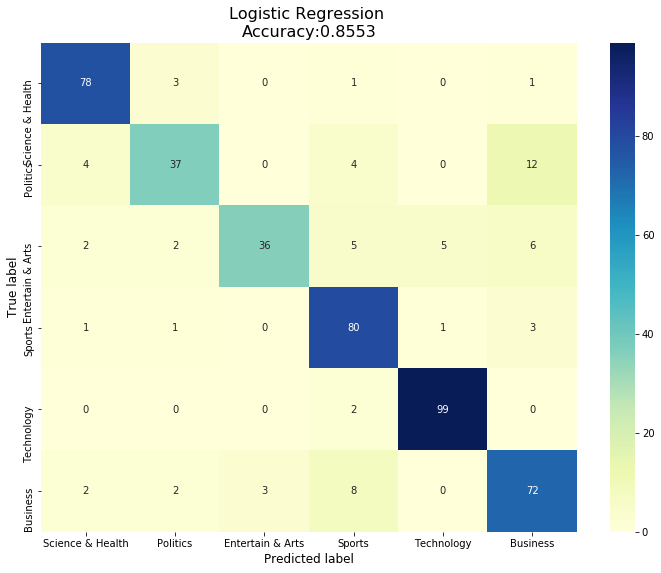

In [30]:
LR()

### Naive Bayes

In [33]:
def NaiveBayes():
    print("Results for Naive Bayes")
    
    classifier = MultinomialNB().fit(x_train_tfidf, y_train.ravel())
    y_pred = classifier.predict(x_test_tfidf)
    
    #transform numerical labels back to non-numerical labels 
    y_test_ori = list(label_encoder.inverse_transform(y_test))
    y_pred_ori = list(label_encoder.inverse_transform(y_pred))
    
    print(accuracy_score(y_test, y_pred))
    print(classification_report(y_test_ori, y_pred_ori))
    
    #plot
    labels = ["Science & Health", "Politics", "Entertain & Arts", 
              "Sports", "Technology", "Business"]
    
    cm = confusion_matrix(y_test, y_pred) 

    # Transform to df for easier plotting
    cm_df = pd.DataFrame(cm,
                         index = labels, 
                         columns = labels)

    plt.figure(figsize = (12,9))
    sns.heatmap(cm_df, annot=True, fmt="d", cmap="YlGnBu")
    plt.title('Naive Bayes \nAccuracy:{0:.4f}'.format(accuracy_score(y_test, y_pred)), fontsize=16)
    plt.ylabel('True label', fontsize = 12)
    plt.xlabel('Predicted label', fontsize = 12)
    plt.savefig("figure/naive_bayes.png")
    plt.show()

Results for Naive Bayes
0.8148936170212766
                                 precision    recall  f1-score   support

              Politics_articles       0.82      0.96      0.89        83
              business_articles       0.93      0.44      0.60        57
entertainment and arts_articles       0.94      0.52      0.67        56
    science and health_articles       0.82      0.90      0.86        86
                sports_articles       0.92      0.97      0.95       101
                  tech_articles       0.64      0.85      0.73        87

                      micro avg       0.81      0.81      0.81       470
                      macro avg       0.85      0.77      0.78       470
                   weighted avg       0.84      0.81      0.80       470



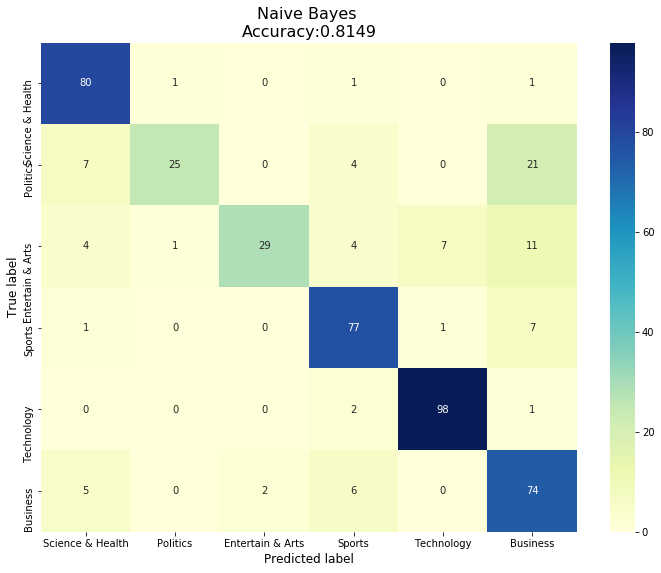

In [34]:
NaiveBayes()

### SVM

In [41]:
def SVM():
    print("Results for Support Vector Machine")
    
    classifier = svm.SVC(gamma='scale').fit(x_train_tfidf, y_train.ravel())
    y_pred = classifier.predict(x_test_tfidf)
    #transform numerical labels back to non-numerical labels 
    y_test_ori = list(label_encoder.inverse_transform(y_test))
    y_pred_ori = list(label_encoder.inverse_transform(y_pred))
    
    print(accuracy_score(y_test, y_pred))
    print(classification_report(y_test_ori, y_pred_ori))
    
    #plot
    labels = ["Science & Health", "Politics", "Entertain & Arts", 
              "Sports", "Technology", "Business"]
    
    cm = confusion_matrix(y_test, y_pred) 

    # Transform to df for easier plotting
    cm_df = pd.DataFrame(cm,
                         index = labels, 
                         columns = labels)

    plt.figure(figsize = (12,9))
    sns.heatmap(cm_df, annot=True, fmt="d", cmap="YlGnBu")
    plt.title('SVM \nAccuracy:{0:.4f}'.format(accuracy_score(y_test, y_pred)), fontsize=16)
    plt.ylabel('True label', fontsize = 12)
    plt.xlabel('Predicted label', fontsize = 12)
    plt.savefig("figure/svm.png")
    plt.show()

Results for Support Vector Machine
0.8574468085106383
                                 precision    recall  f1-score   support

              Politics_articles       0.94      0.93      0.93        83
              business_articles       0.83      0.61      0.71        57
entertainment and arts_articles       0.91      0.70      0.79        56
    science and health_articles       0.79      0.92      0.85        86
                sports_articles       0.98      0.96      0.97       101
                  tech_articles       0.73      0.87      0.80        87

                      micro avg       0.86      0.86      0.86       470
                      macro avg       0.86      0.83      0.84       470
                   weighted avg       0.87      0.86      0.86       470



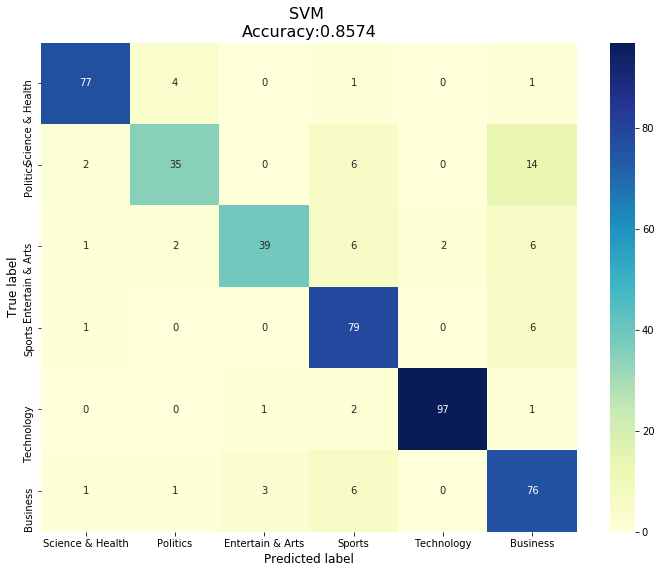

In [42]:
SVM()

### Random Forest

In [43]:
def RandomForest():
    print("Results for Random Forest")

    classifier = RandomForestClassifier(n_estimators=40).fit(x_train_tfidf, y_train.ravel())
    y_pred = classifier.predict(x_test_tfidf)
    #transform numerical labels back to non-numerical labels 
    y_test_ori = list(label_encoder.inverse_transform(y_test))
    y_pred_ori = list(label_encoder.inverse_transform(y_pred))
    
    print(accuracy_score(y_test, y_pred))
    print(classification_report(y_test_ori, y_pred_ori))
    
    #plot
    labels = ["Science & Health", "Politics", "Entertain & Arts", 
              "Sports", "Technology", "Business"]
    
    cm = confusion_matrix(y_test, y_pred) 

    # Transform to df for easier plotting
    cm_df = pd.DataFrame(cm,
                         index = labels, 
                         columns = labels)

    plt.figure(figsize = (12,9))
    sns.heatmap(cm_df, annot=True, fmt="d", cmap="YlGnBu")
    plt.title('Random Forest \nAccuracy:{0:.4f}'.format(accuracy_score(y_test, y_pred)), fontsize=16)
    plt.ylabel('True label', fontsize = 12)
    plt.xlabel('Predicted label', fontsize = 12)
    plt.savefig("figure/random_forest.png")
    plt.show()

Results for Random Forest
0.8361702127659575
                                 precision    recall  f1-score   support

              Politics_articles       0.86      0.96      0.91        83
              business_articles       0.74      0.54      0.63        57
entertainment and arts_articles       0.78      0.75      0.76        56
    science and health_articles       0.87      0.87      0.87        86
                sports_articles       0.95      0.95      0.95       101
                  tech_articles       0.73      0.79      0.76        87

                      micro avg       0.84      0.84      0.84       470
                      macro avg       0.82      0.81      0.81       470
                   weighted avg       0.83      0.84      0.83       470



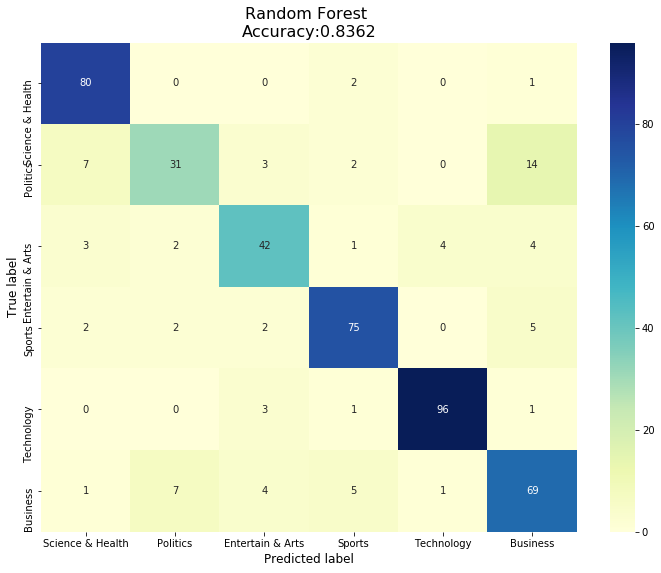

In [44]:
RandomForest()

### XGBoost

In [45]:
def Xgboost():
    print("Results for XGBoost")
    
    classifier = xgboost.XGBClassifier().fit(x_train_tfidf, y_train.ravel())
    y_pred = classifier.predict(x_test_tfidf)
    #transform numerical labels back to non-numerical labels 
    y_test_ori = list(label_encoder.inverse_transform(y_test))
    y_pred_ori = list(label_encoder.inverse_transform(y_pred))
    
    print(accuracy_score(y_test, y_pred))
    print(classification_report(y_test_ori, y_pred_ori))
    
    #plot
    labels = ["Science & Health", "Politics", "Entertain & Arts", 
              "Sports", "Technology", "Business"]
    
    cm = confusion_matrix(y_test, y_pred) 

    # Transform to df for easier plotting
    cm_df = pd.DataFrame(cm,
                         index = labels, 
                         columns = labels)

    plt.figure(figsize = (12,9))
    sns.heatmap(cm_df, annot=True, fmt="d", cmap="YlGnBu")
    plt.title('XGBoost \nAccuracy:{0:.4f}'.format(accuracy_score(y_test, y_pred)), fontsize=16)
    plt.ylabel('True label', fontsize = 12)
    plt.xlabel('Predicted label', fontsize = 12)
    plt.savefig("figure/xgboost.png")
    plt.show()

Results for XGBoost
0.8276595744680851
                                 precision    recall  f1-score   support

              Politics_articles       0.86      0.92      0.89        83
              business_articles       0.71      0.68      0.70        57
entertainment and arts_articles       0.73      0.68      0.70        56
    science and health_articles       0.86      0.86      0.86        86
                sports_articles       0.96      0.90      0.93       101
                  tech_articles       0.76      0.82      0.78        87

                      micro avg       0.83      0.83      0.83       470
                      macro avg       0.81      0.81      0.81       470
                   weighted avg       0.83      0.83      0.83       470



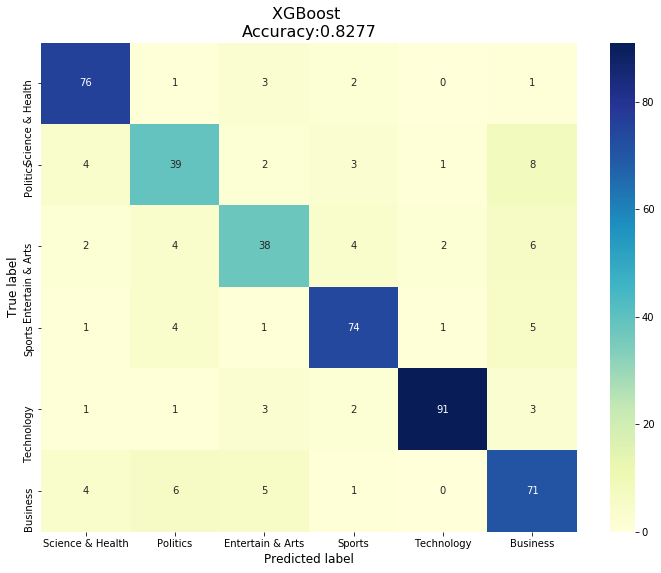

In [46]:
Xgboost()

### Shallow Neural Network

In [47]:
def NN():
    print("Results for Shallow Neural Network")
    
    
    classifier = MLPClassifier(solver='adam', alpha=1e-5, 
                              hidden_layer_sizes=(100, 20), 
                              random_state=1, max_iter=400).fit(x_train_tfidf, y_train.ravel())
    y_pred = classifier.predict(x_test_tfidf)
    #transform numerical labels back to non-numerical labels 
    y_test_ori = list(label_encoder.inverse_transform(y_test))
    y_pred_ori = list(label_encoder.inverse_transform(y_pred))
    
    print(accuracy_score(y_test, y_pred))
    print(classification_report(y_test_ori, y_pred_ori))
    
    #plot
    labels = ["Science & Health", "Politics", "Entertain & Arts", 
              "Sports", "Technology", "Business"]
    
    cm = confusion_matrix(y_test, y_pred) 

    # Transform to df for easier plotting
    cm_df = pd.DataFrame(cm,
                         index = labels, 
                         columns = labels)

    plt.figure(figsize = (12,9))
    sns.heatmap(cm_df, annot=True, fmt="d", cmap="YlGnBu")
    plt.title('Shallow Neural Network \nAccuracy:{0:.4f}'.format(accuracy_score(y_test, y_pred)), fontsize=16)
    plt.ylabel('True label', fontsize = 12)
    plt.xlabel('Predicted label', fontsize = 12)
    plt.savefig("figure/shallow_nn.png")
    plt.show()

Results for Shallow Neural Network
0.874468085106383
                                 precision    recall  f1-score   support

              Politics_articles       0.91      0.93      0.92        83
              business_articles       0.78      0.79      0.78        57
entertainment and arts_articles       0.89      0.71      0.79        56
    science and health_articles       0.90      0.88      0.89        86
                sports_articles       0.97      0.98      0.98       101
                  tech_articles       0.77      0.85      0.81        87

                      micro avg       0.87      0.87      0.87       470
                      macro avg       0.87      0.86      0.86       470
                   weighted avg       0.88      0.87      0.87       470



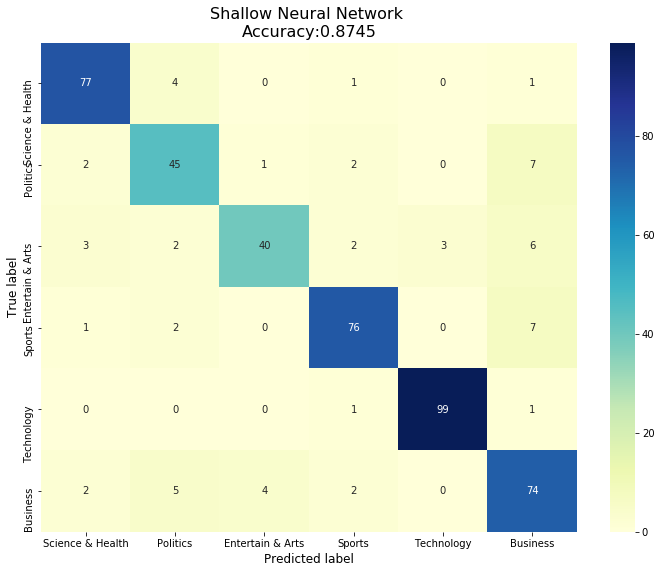

In [48]:
NN()

### LSTM

In [29]:
def LSTM_model():
    print("Results for LSTM")
    
    top_words = 100
    embedding_vecor_length = 8
    max_review_length = x_train_tfidf.shape.[1]
    model = Sequential()
    model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
    model.add(LSTM(16))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())

    model.fit(x_train_tfidf, y_train.ravel(), validation_data=(x_test_tfidf, y_test), 
              epochs=1, batch_size=64)   

In [30]:
#LSTM_model()

Results for LSTM
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 43372, 8)          800       
_________________________________________________________________
lstm_9 (LSTM)                (None, 16)                1600      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 17        
Total params: 2,417
Trainable params: 2,417
Non-trainable params: 0
_________________________________________________________________
None
Train on 1866 samples, validate on 470 samples
Epoch 1/1
1866/1866 [==============================] - 1113s 597ms/step - loss: 0.4813 - acc: 0.1206 - val_loss: 0.0144 - val_acc: 0.1213
